# Don't Get Kicked

In this notebook, we will make predictions whether a car is a "bad buy".
See the [kaggle competetion](https://www.kaggle.com/competitions/DontGetKicked/overview/background) for more details.

## Project Setup

In [1]:
# import modules and magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import PrecisionRecallDisplay

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_kick(filename):
    kick = pd.read_csv(filename)
    kick.PurchDate = pd.to_datetime(kick.PurchDate, format="%m/%d/%Y")

    kick.VehYear = pd.Categorical(kick.VehYear)
    cat_columns = [
        "Auction",
        "Make",
        "Model",
        "Trim",
        "SubModel",
        "Color",
        "Transmission",
        "WheelType",
        "Nationality",
        "Size",
        "TopThreeAmericanName",
        "PRIMEUNIT",
        "AUCGUART",
        "VNST",
    ]
    for col in cat_columns:
        kick[col] = kick[col].str.upper()

    # Buyer ID is not useful for prediction of a new buyer
    kick.drop(columns={"BYRNO"}, inplace=True)
    # Submodel is not useful without some automobile domain knowledge
    # kick.drop(columns={"SubModel"}, inplace=True)
    # WheelTypeID is already covered by WheelType
    kick.drop(columns={"WheelTypeID"}, inplace=True)

    # Transform Price Columns to assist model training
    # The difference between MMR price and purchase price can indicate issues with a car
    # AutoGluon will normalize these columns later on
    price_cols = [
        "MMRAcquisitionAuctionAveragePrice",
        "MMRAcquisitionAuctionCleanPrice",
        "MMRAcquisitionRetailAveragePrice",
        "MMRAcquisitonRetailCleanPrice",
        "MMRCurrentAuctionAveragePrice",
        "MMRCurrentAuctionCleanPrice",
        "MMRCurrentRetailAveragePrice",
        "MMRCurrentRetailCleanPrice",
    ]

    for price_col in price_cols:
        kick[f"{price_col}_diff"] = kick[price_col] - kick["VehBCost"]
    kick.drop(columns=price_cols, inplace=True)

    return kick


kick = read_kick("../data/training.csv")
kick_test = read_kick("../data/test.csv")

<IPython.core.display.Javascript object>

## EDA

<AxesSubplot:xlabel='IsBadBuy'>

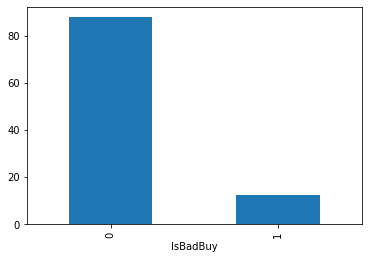

<IPython.core.display.Javascript object>

In [3]:
# Approx 12% of purchases are "Bad".
(100 * kick.groupby("IsBadBuy").size() / len(kick)).plot(kind="bar")

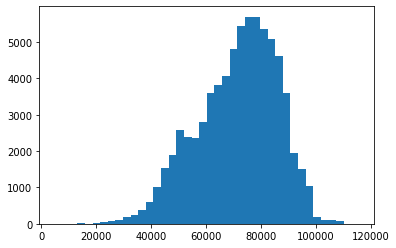

<IPython.core.display.Javascript object>

In [4]:
# Might be helpful to square odometer to remove skew
# I'll ignore this for now but would revise with more time.
odo_hist = plt.hist(kick.VehOdo, bins=40)

The following plots show the difference between 
 - retail values (aka, end customer is buying the car)
 - Auction values (aka, car dealership is buying the car as suggested by Manheim Automated Pricing Models), 
 - And the actual purchase price of the car at the Auction (as paid by the auction purchaser)
 
A dealer shouldn't be willing to pay more than the Fair Auction value and should look to make the profit on the purchase of the vehicle.  Therefore the Actual purchase price should be less than both Auction and Retail values.

When the discrepancy between actual purchase price and Auction values is too high, it might indicate that there is something wrong with the vehicle.

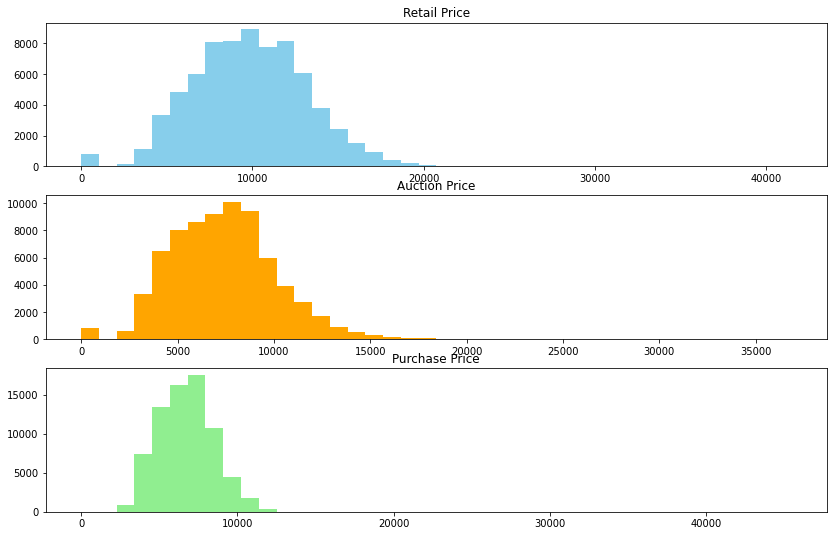

<IPython.core.display.Javascript object>

In [5]:
kick_raw = pd.read_csv("../data/training.csv")

plt.rcParams["figure.figsize"] = (14, 9)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

retail_hist = ax1.hist(
    kick_raw.MMRAcquisitonRetailCleanPrice, bins=40, label="Retail", color="skyblue"
)
ax1.set_title("Retail Price")
auction_hist = ax2.hist(
    kick_raw.MMRAcquisitionAuctionCleanPrice, bins=40, label="Auction", color="orange"
)
ax2.set_title("Auction Price")
auction_hist = ax3.hist(kick_raw.VehBCost, bins=40, label="Auction", color="lightgreen")
ax3.set_title("Purchase Price")

plt.show()

The scatter plot below shows multiple correlation between the variations on MMR value.  With more time, I would use PCA on these data before feeding these variables into the classification model.  Many of the models used can still deal with the multicolinearity anyway.

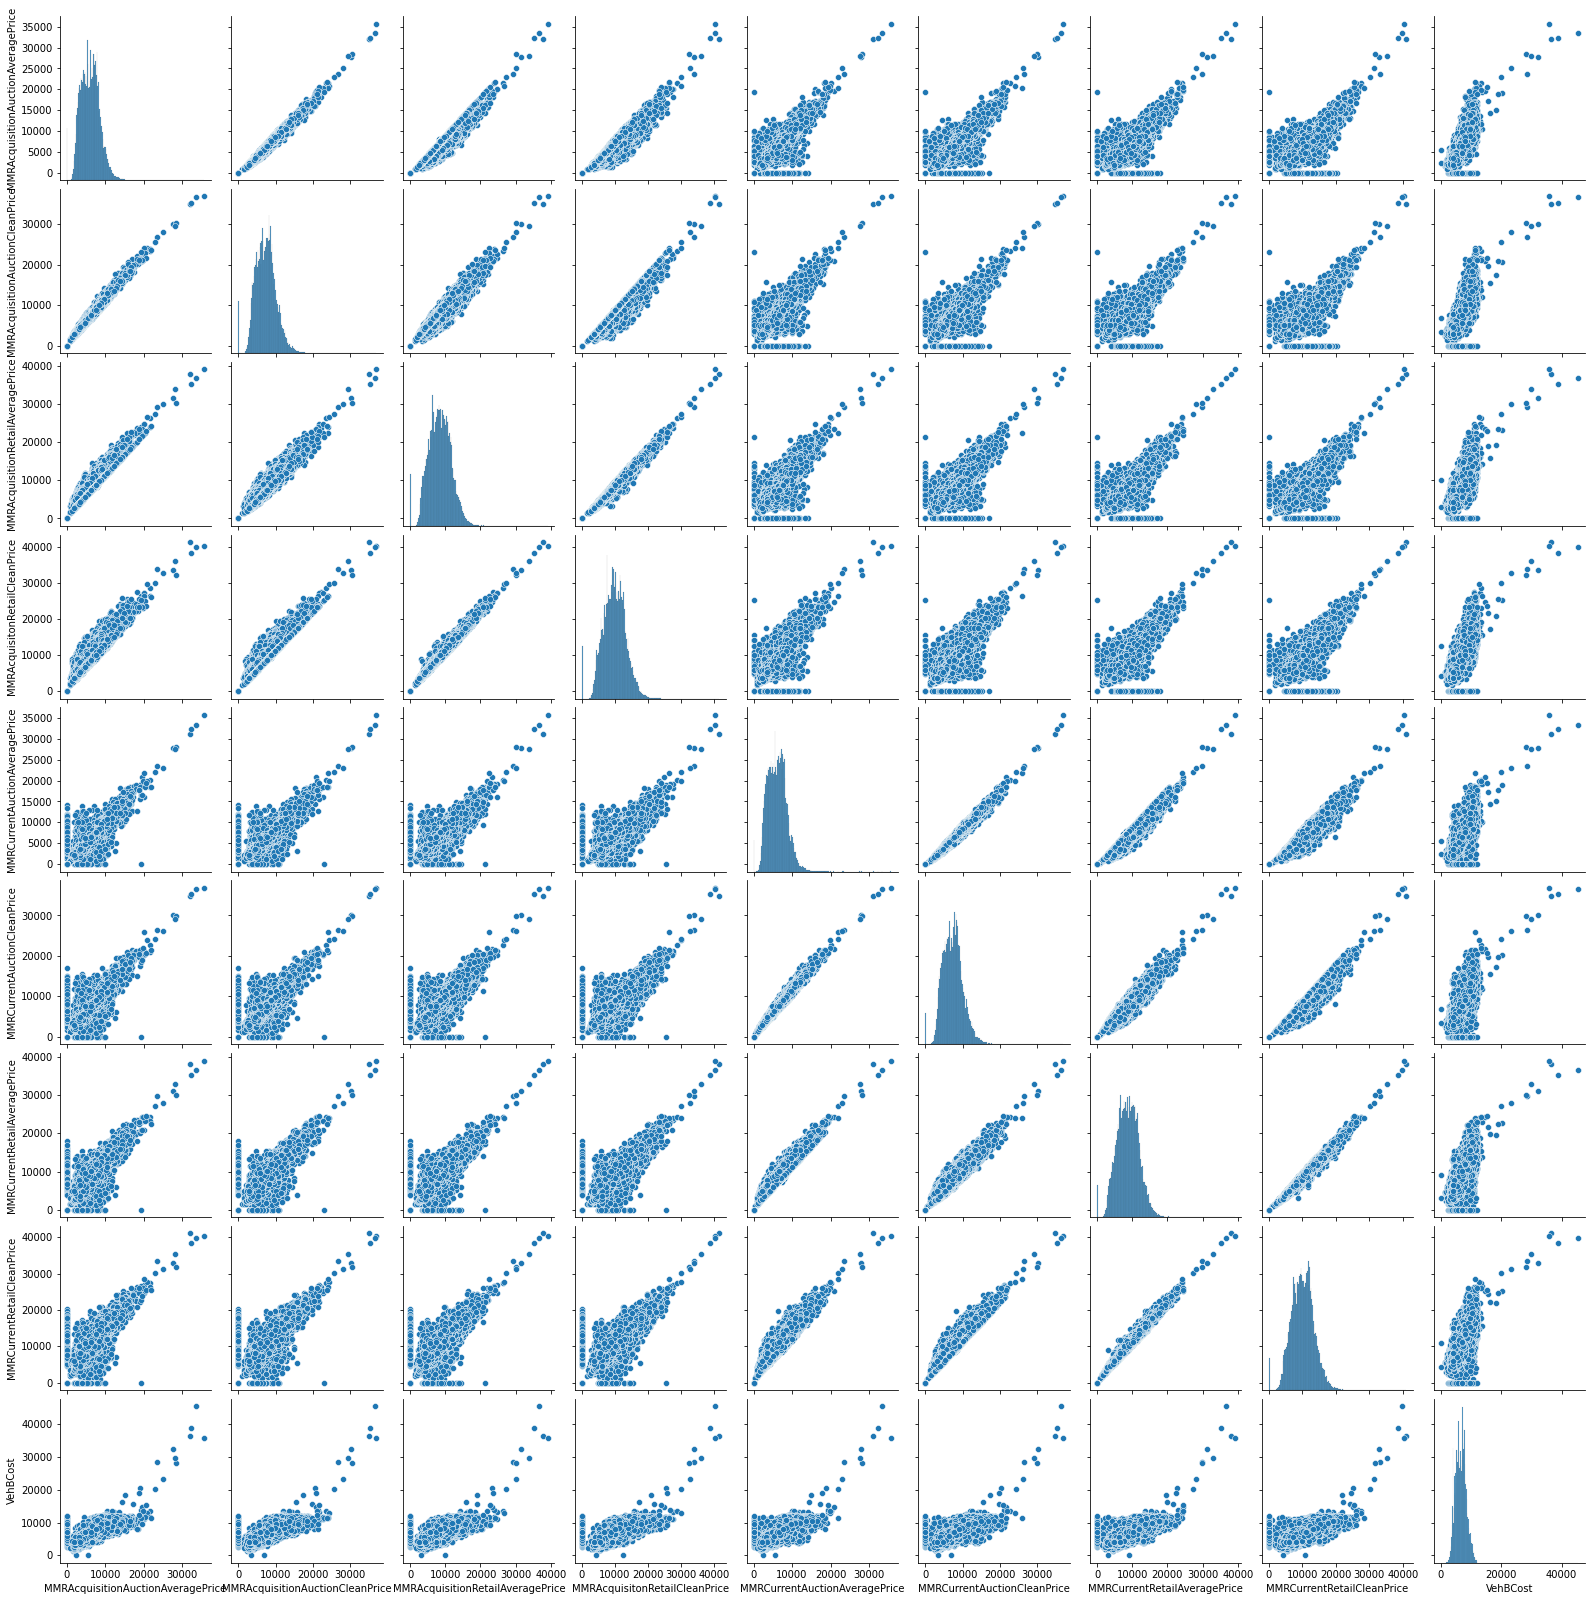

<IPython.core.display.Javascript object>

In [6]:
sns.pairplot(
    data=kick_raw[
        [
            "MMRAcquisitionAuctionAveragePrice",
            "MMRAcquisitionAuctionCleanPrice",
            "MMRAcquisitionRetailAveragePrice",
            "MMRAcquisitonRetailCleanPrice",
            "MMRCurrentAuctionAveragePrice",
            "MMRCurrentAuctionCleanPrice",
            "MMRCurrentRetailAveragePrice",
            "MMRCurrentRetailCleanPrice",
            "VehBCost",
        ]
    ]
)

There might be some autocorrelation between IsBadBuy.
Maybe lots of bad cars come onto the auction at the same time.

[Text(0.5, 0, 'Purchase Date'), Text(0, 0.5, 'Percent Bad Buy')]

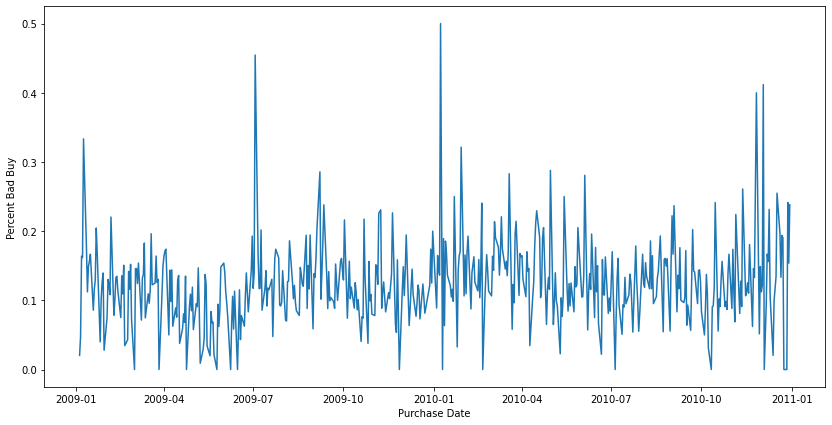

<IPython.core.display.Javascript object>

In [7]:
# There might be some autocorrelation between IsBadBuy.
# Maybe lots of bad cars come onto the auction at the same time.
plt.rcParams["figure.figsize"] = (14, 7)
bb_over_time = kick.groupby(["PurchDate"])["IsBadBuy"].mean().reset_index()
bb_ts = sns.lineplot(data=bb_over_time, x="PurchDate", y="IsBadBuy")
bb_ts.set(xlabel="Purchase Date", ylabel="Percent Bad Buy")

--------------------

## Binary Classification

**Data Science Philosophy**: The Kaggle overview asks for a classification model to choose between 0 - Good Buy and 1 - Bad Buy.  We first have to choose what our goal in classification is.  I would argue that dealerships are greatly hurt by bad buy purchases in terms of wasted holding costs, wasted labor, storage space, etc.  Overall I would assume that most car dealerships would do their best to avoid bad purchases even if it means giving up on quite a few good purchases that could be profitable.

What does this mean for our Classification model? We would like to prioritize recall (the ability to detect bad buys) over precision. With imbalanced class probabilities, accuracy is definitely not an appropriate objective in this model.

**Feature Engineering**: I demonstrated a bit of manual feature engineering in the EDA section above, but I'll leave most of the work to an automated feature engineering process done by the Autogluon python module.  This saves time and effort but should be reviewed manually for mistakes before any production launch of a model. Better hand-curated feature engineering can decrease the training time needed by Neural Net models for example.

**Classification Models**: I chose to use AutoGluon for this classification problem because (1) it is quick and easy, (2) It gives good results through a stacked ensemble of populare machine learning models, and (3) it provides optimization according to the recall metric we are aiming to use for this problem.  

**Validation Sets Design** Autogluon performs hyperparameter tuning automatically so there is no need to create CV sets for hyperparameter tuning externally.  However, I would still like to know the generalization error / performance of the model on a holdout set.  I set aside 1/10th of the training set to use as a holdout in order to estimate the recall of the model.  The remaining 9/10ths of the training data is used on a first pass to train (and tune hyperparameters internally via autogluon) for evaluation on this holdout set.

For final prediction (aka, what would be a production launch of this model) I combine the train and holdout sets into one dataset which I am calling *prod_data*.  We'll re-train Autogluon on this prod_data set to obtain final test set predictions.

In [8]:
# create generalization error set

# I would normally use sklearn train_test_split, but this separates the y values
# which we don't need for AutoGluon
holdout_indx = np.random.choice(
    len(kick), size=int(np.floor(len(kick) / 10)), replace=False, p=None
)
kick_holdout = kick.iloc[holdout_indx]
kick_train = kick[~kick.index.isin(list(holdout_indx))]

print(f"kick has {kick.shape[0]} rows")
print(f"kick_train has {kick_train.shape[0]} rows")
print(f"kick holdout has {kick_holdout.shape[0]} rows")
print(f"kick test has {kick_test.shape[0]} rows")

kick has 72983 rows
kick_train has 65685 rows
kick holdout has 7298 rows
kick test has 48707 rows


<IPython.core.display.Javascript object>

In [9]:
prod_data = TabularDataset(kick.drop(columns=["RefId"]))
train_data = TabularDataset(kick_train.drop(columns=["RefId"]))
holdout_data = TabularDataset(kick_holdout.drop(columns=["RefId"]))
test_data = TabularDataset(kick_test)

<IPython.core.display.Javascript object>

In [10]:
train_data.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,IsOnlineSale,WarrantyCost,MMRAcquisitionAuctionAveragePrice_diff,MMRAcquisitionAuctionCleanPrice_diff,MMRAcquisitionRetailAveragePrice_diff,MMRAcquisitonRetailCleanPrice_diff,MMRCurrentAuctionAveragePrice_diff,MMRCurrentAuctionCleanPrice_diff,MMRCurrentRetailAveragePrice_diff,MMRCurrentRetailCleanPrice_diff
0,0,2009-12-07,ADESA,2006,3,MAZDA,MAZDA3,I,4D SEDAN I,RED,...,0,1113,1055.0,2729.0,4536.0,6500.0,351.0,1452.0,4497.0,5309.0
1,0,2009-12-07,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,0,1053,-746.0,783.0,3297.0,4972.0,-144.0,1622.0,3774.0,5191.0
2,0,2009-12-07,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,0,1389,-1698.0,-140.0,2043.0,3557.0,-865.0,657.0,2246.0,3802.0
3,0,2009-12-07,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,0,630,-2207.0,-1425.0,558.0,1590.0,-2256.0,-1454.0,275.0,1418.0
5,0,2009-12-07,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,...,0,594,-1699.0,-692.0,1106.0,2977.0,-891.0,227.0,2549.0,3851.0


<IPython.core.display.Javascript object>

In [11]:
test_data.head()

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,IsOnlineSale,WarrantyCost,MMRAcquisitionAuctionAveragePrice_diff,MMRAcquisitionAuctionCleanPrice_diff,MMRAcquisitionRetailAveragePrice_diff,MMRAcquisitonRetailCleanPrice_diff,MMRCurrentAuctionAveragePrice_diff,MMRCurrentAuctionCleanPrice_diff,MMRCurrentRetailAveragePrice_diff,MMRCurrentRetailCleanPrice_diff
0,73015,2009-12-02,ADESA,2005,4,PONTIAC,GRAND PRIX,BAS,4D SEDAN,SILVER,...,0,2152,-1468.0,-114.0,-565.0,897.0,-1595.0,-319.0,2057.0,3252.0
1,73016,2009-12-02,ADESA,2005,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,...,0,1118,-1798.0,-615.0,-938.0,340.0,-1655.0,-590.0,1262.0,2996.0
2,73017,2009-12-02,ADESA,2006,3,DODGE,DURANGO 2WD V8,ADV,4D SUV 4.7L ADVENTURER,SILVER,...,0,1215,544.0,3341.0,1864.0,4884.0,1183.0,2466.0,5640.0,6812.0
3,73018,2009-12-02,ADESA,2002,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,...,0,1933,-1592.0,-608.0,-887.0,175.0,-1222.0,-543.0,1575.0,2248.0
4,73019,2009-12-02,ADESA,2007,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,...,0,920,913.0,2243.0,1814.0,3250.0,913.0,2243.0,1814.0,3250.0


<IPython.core.display.Javascript object>

In [12]:
label = "IsBadBuy"
save_path_beta = (
    "agModels-predictClass-beta"  # specifies folder to store trained models
)

time_limit = 60 * 10  # Train for 10 minutes
# metric = "roc_auc"
# metric = "balanced_accuracy"
# metric = "f1"
metric = "recall"  # other choices above
predictor = TabularPredictor(label, eval_metric=metric, path=save_path_beta).fit(
    train_data,
    time_limit=time_limit,
    presets="medium_quality",
    # ag_args_fit={"num_gpus": 1}, # uncomment for GPU training
)

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "agModels-predictClass-beta/"
AutoGluon Version:  0.6.2
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #102-Ubuntu SMP Fri Nov 5 16:31:28 UTC 2021
Train Data Rows:    65685
Train Data Columns: 30
Label Column: IsBadBuy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12980.48 MB
	Train Data (Original)  Memory Usage: 62.21 MB

<IPython.core.display.Javascript object>

### Holdout Set Performance

In [13]:
predictor.leaderboard(holdout_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,0.312500,0.407166,0.086745,0.042500,140.031502,0.086745,0.042500,140.031502,1,True,12
1,WeightedEnsemble_L2,0.312500,0.407166,0.088952,0.047884,141.766650,0.002207,0.005384,1.735149,2,True,14
2,NeuralNetFastAI,0.281798,0.328990,0.148524,0.052546,67.861175,0.148524,0.052546,67.861175,1,True,10
3,LightGBM,0.265351,0.325733,0.032650,0.022119,2.235929,0.032650,0.022119,2.235929,1,True,4
4,CatBoost,0.259868,0.325733,0.060521,0.033253,2.960231,0.060521,0.033253,2.960231,1,True,7
5,LightGBMLarge,0.258772,0.325733,0.045204,0.029457,3.820436,0.045204,0.029457,3.820436,1,True,13
6,LightGBMXT,0.252193,0.312704,0.032190,0.020229,1.945483,0.032190,0.020229,1.945483,1,True,3
7,XGBoost,0.243421,0.319218,0.058545,0.023222,2.520480,0.058545,0.023222,2.520480,1,True,11
8,RandomForestEntr,0.217105,0.244300,0.286072,0.108734,10.010756,0.286072,0.108734,10.010756,1,True,6
9,RandomForestGini,0.216009,0.257329,0.321160,0.119894,11.146567,0.321160,0.119894,11.146567,1,True,5


<IPython.core.display.Javascript object>

In [14]:
y_pred_holdout = predictor.predict(holdout_data)
y_proba_holdout = predictor.predict_proba(holdout_data)
perf = predictor.evaluate_predictions(
    y_true=holdout_data.IsBadBuy, y_pred=y_proba_holdout, auxiliary_metrics=True
)

Evaluation: recall on test data: 0.3125
Evaluations on test data:
{
    "recall": 0.3125,
    "accuracy": 0.8792819950671417,
    "balanced_accuracy": 0.6363627466332602,
    "mcc": 0.34482758959355536,
    "roc_auc": 0.7150426886390734,
    "f1": 0.3928325292901447,
    "precision": 0.5287569573283859
}


<IPython.core.display.Javascript object>

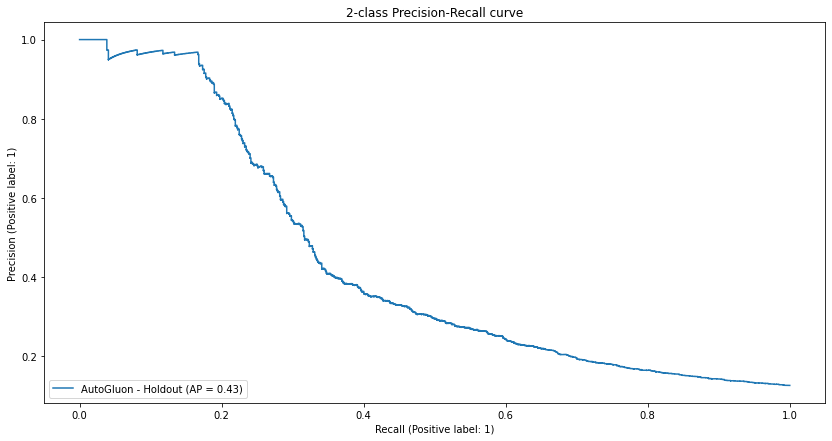

<IPython.core.display.Javascript object>

In [15]:
display = PrecisionRecallDisplay.from_predictions(
    kick_holdout.IsBadBuy, y_proba_holdout.loc[:, 1], name="AutoGluon - Holdout"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Production Model

In [16]:
save_path_prod = "agModels-predictClass-prod"  #
predictor = TabularPredictor(label, eval_metric=metric, path=save_path_prod).fit(
    train_data,
    time_limit=time_limit,  # I should increase the time and presets quality for a "real deal"
    presets="medium_quality",
    # ag_args_fit={"num_gpus": 1}, # uncomment for GPU training
)

Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "agModels-predictClass-prod/"
AutoGluon Version:  0.6.2
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #102-Ubuntu SMP Fri Nov 5 16:31:28 UTC 2021
Train Data Rows:    65685
Train Data Columns: 30
Label Column: IsBadBuy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9508.68 MB
	Train Data (Original)  Memory Usage: 62.21 MB 

<IPython.core.display.Javascript object>

In [17]:
y_proba_test = predictor.predict_proba(test_data)
y_pred_test = predictor.predict(test_data)
results = pd.concat([test_data.RefId, y_proba_test.iloc[:, 1], y_pred_test], axis=1)
results.columns = ["RefId", "Predicted_Probability", "Predicted_Class"]
results["Predicted_Class_type"] = np.where(results.Predicted_Class == 0, "Good", "Bad")
results.head()

,RefId,Predicted_Probability,Predicted_Class,Predicted_Class_type
0,73015,0.024603,0,Good
1,73016,0.030288,0,Good
2,73017,0.000777,0,Good
3,73018,0.045123,0,Good
4,73019,0.985404,1,Bad


<IPython.core.display.Javascript object>

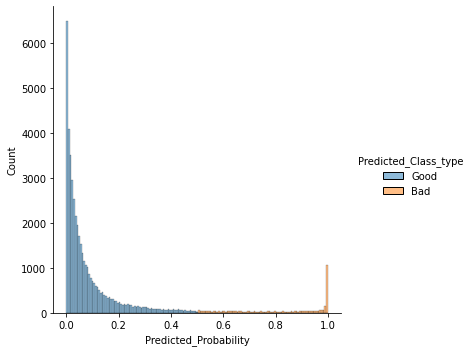

<IPython.core.display.Javascript object>

In [18]:
sns.displot(results, x="Predicted_Probability", hue="Predicted_Class_type")

In [19]:
results.to_csv("../data/predictions.csv", index=False)

<IPython.core.display.Javascript object>

## Summary:

Since the model was trained with recall in mind, the decision boundary here is p = 0.5.  Users can adjust based on risk tolerance to lower this decision boundary in order to avoid more bad purchases, but will miss out on some profitable deals as a result.

The Model results are saved to the predictions.csv file and will be submitted with this notebook for this project.